In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms, Compose
from torchvision.io import read_image

In [2]:
torch.manual_seed(57)

In [3]:
class pre_process_data(Dataset):
    def __init__(self, images_dir, img_transforms=None, target_transforms=None):
        self.images_dir = images_dir
        self.img_transforms = img_transforms
        self.target_transforms = target_transforms
        self.img_labels = os.listdir(self.images_dir)
        
       
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.img_labels[idx])
        image = read_image(img_path)
        image = image.float()
        image = image / 255.0
        label = self.calculate_label(self.img_labels[idx])
        #print(self.img_labels[idx])
       
        if self.img_transforms:
            image = self.img_transforms(image)
        if self.target_transforms:
            label = self.target_transforms(label)
        
        return image, label
        
    def calculate_mean_std(self, dataloader):
        mean = 0.0
        std = 0.0
        total_images_count = 0

        for images, _ in dataloader:
            batch_samples = images.size(0)  # Number of images in the batch
            total_images_count += batch_samples
            
            images = images.view(batch_samples, images.size(1), -1)  # Flatten the image pixels
            mean += images.float().mean(2).sum(0)
            std += images.float().std(2).sum(0)

        mean /= total_images_count
        std /= total_images_count

        return mean.item(), std.item()

    
    def calculate_label(self, img_basename):
        tmp = img_basename[:len(img_basename)-4].split("_")
        row = tmp[2]
        rod_id = int(tmp[3])
        if row in {"A", "B", "E", "F", "I", "J"}:
            label = 4-(rod_id % 4)
        else:
            label = (rod_id % 4)+1
        return label

In [4]:
dataset_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.ToTensor(),
])

In [5]:
dataset =pre_process_data(images_dir="QR_d_best",img_transforms=dataset_transform)

In [6]:
dataloader = DataLoader(dataset, batch_size=32, num_workers=4)

In [7]:
mean, std = dataset.calculate_mean_std(dataloader)
print(mean)
print(std)
mean = round(mean, 3)
std = round(std, 3)
print(mean)
print(std)

0.6096397638320923
0.14037656784057617
0.61
0.14


In [8]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

print(train_size)
print(test_size)

3888
432


In [9]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[mean], std = [std])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=[mean], std=[std])
])

def target_transform(label):
    one_hot = torch.zeros((4))
    one_hot[label - 1] = 1.0
    return one_hot

In [11]:
train_dataset.dataset.img_transforms = train_transform
train_dataset.dataset.target_transforms = target_transform
test_dataset.dataset.img_transforms = test_transform
test_dataset.dataset.target_transforms = target_transform

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [13]:
image_counter = 0
label_counter = 0
for images, labels in test_loader:
    image_counter += len(images)
    label_counter += len(labels)
    
print(image_counter)
print(label_counter)
print(images.shape)


432
432
torch.Size([16, 1, 64, 64])


In [14]:
import matplotlib.pyplot as plt

tensor([[2.2255, 2.2255, 2.5616,  ..., 1.4132, 1.3291, 1.4412],
        [2.2535, 2.2255, 2.5056,  ..., 1.4972, 1.4132, 1.3852],
        [2.3095, 2.5056, 2.5336,  ..., 1.2731, 1.5252, 1.4132],
        ...,
        [1.5252, 1.5812, 1.5252,  ..., 1.4132, 1.4132, 1.4132],
        [1.4412, 1.4692, 1.4132,  ..., 1.4412, 1.4412, 1.4132],
        [1.4132, 1.4132, 1.3852,  ..., 1.4132, 1.4132, 1.3852]])
tensor([0., 0., 0., 1.])


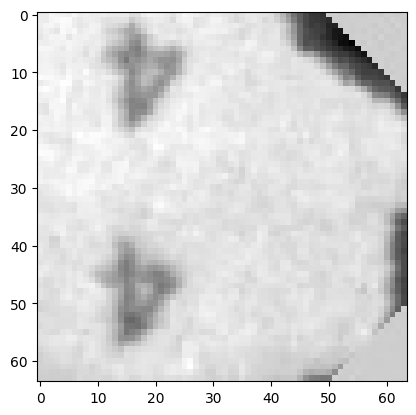

In [15]:
for images, _ in train_loader:
    print(images[6][0])
    print(_[6])
    plt.imshow(images[6][0], cmap="gray")
    plt.show()
    break

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [17]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("Running on GPU")
else:
    device = "cpu"
    print("Running on CPU")
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        x = torch.randn((1, 64, 64))
        self._to_linear = None
        
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 4)
        
    def convs(self, X):
        X = F.max_pool2d(F.relu(self.conv1(X)), (2, 2))
        X = F.max_pool2d(F.relu(self.conv2(X)), (2, 2))
        X = F.max_pool2d(F.relu(self.conv3(X)), (2, 2))
        X = F.max_pool2d(F.relu(self.conv4(X)), (2, 2))
        if self._to_linear is None:
            self._to_linear = X.shape[0] * X.shape[1] * X.shape[2]
            
        return X
    
    def forward(self, X):
        X = self.convs(X)
        X = X.view(-1, self._to_linear)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        
        return X
    


Running on GPU


In [18]:
num_recognition = Net().to(device)

In [19]:
optimizer = optim.Adam(num_recognition.parameters(), lr=0.0001)
loss_function  = nn.CrossEntropyLoss()
batch_size = 100
epochs = 20

def train(num_recognition):
    for epoch in range(epochs):
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            num_recognition.zero_grad()
            #optimizer.zero_grad()
            output = num_recognition(images)
            
            loss = loss_function(output, labels)
            
            loss.backward()
            optimizer.step()
        
        print(f"epoch: {epoch}, loss: {loss}")

In [20]:
train(num_recognition)

100%|██████████| 122/122 [00:00<00:00, 126.08it/s]


epoch: 0, loss: 1.0173938274383545


100%|██████████| 122/122 [00:00<00:00, 238.51it/s]


epoch: 1, loss: 0.2836615741252899


100%|██████████| 122/122 [00:00<00:00, 237.52it/s]


epoch: 2, loss: 0.12660667300224304


100%|██████████| 122/122 [00:00<00:00, 231.80it/s]


epoch: 3, loss: 0.16857179999351501


100%|██████████| 122/122 [00:00<00:00, 235.73it/s]


epoch: 4, loss: 0.00910724513232708


100%|██████████| 122/122 [00:00<00:00, 243.60it/s]


epoch: 5, loss: 0.12689617276191711


100%|██████████| 122/122 [00:00<00:00, 238.42it/s]


epoch: 6, loss: 0.10128258168697357


100%|██████████| 122/122 [00:00<00:00, 231.28it/s]


epoch: 7, loss: 0.0164065919816494


100%|██████████| 122/122 [00:00<00:00, 237.11it/s]


epoch: 8, loss: 0.01592325046658516


100%|██████████| 122/122 [00:00<00:00, 234.47it/s]


epoch: 9, loss: 0.012732368893921375


100%|██████████| 122/122 [00:00<00:00, 234.58it/s]


epoch: 10, loss: 0.10715445876121521


100%|██████████| 122/122 [00:00<00:00, 234.89it/s]


epoch: 11, loss: 0.034660451114177704


100%|██████████| 122/122 [00:00<00:00, 227.67it/s]


epoch: 12, loss: 0.0001638564426684752


100%|██████████| 122/122 [00:00<00:00, 237.74it/s]


epoch: 13, loss: 0.0014182113809511065


100%|██████████| 122/122 [00:00<00:00, 230.09it/s]


epoch: 14, loss: 0.00039084706804715097


100%|██████████| 122/122 [00:00<00:00, 226.52it/s]


epoch: 15, loss: 0.0007303052116185427


100%|██████████| 122/122 [00:00<00:00, 232.77it/s]


epoch: 16, loss: 0.00012965218047611415


100%|██████████| 122/122 [00:00<00:00, 230.32it/s]


epoch: 17, loss: 0.03848392888903618


100%|██████████| 122/122 [00:00<00:00, 235.40it/s]


epoch: 18, loss: 2.550193494244013e-05


100%|██████████| 122/122 [00:00<00:00, 233.55it/s]

epoch: 19, loss: 0.0041120960377156734


In [21]:
def test(num_recognition):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = num_recognition(images.to(device))
            # print(output.shape)
            predicted_class = torch.argmax(output, dim=1)
            # print(predicted_class)
            true_class = torch.argmax(labels.to(device), dim=1)
            # print(true_class)
            comparision = predicted_class == true_class
            count_true = comparision.sum().item()
            len_comparision = comparision.numel()
            count_false = len_comparision - count_true
            total += len_comparision
            correct += count_true
            # print(count_true)
            # print(count_false)
            # print(predicted_class == true_class)
            # print(comparision.shape)
            # print(predicted_class.shape)
            # break

    print(f"Accuracy: {round(correct/total, 3)}")
    print(correct)

In [22]:
test(num_recognition)

100%|██████████| 14/14 [00:00<00:00, 109.75it/s]

Accuracy: 0.988
427


In [23]:
from torch.utils.tensorboard import SummaryWriter

In [24]:
writer = SummaryWriter("runs/logs")

In [25]:
def test_model(num_recognition):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = num_recognition(images.to(device))
            # print(output.shape)
            predicted_class = torch.argmax(output, dim=1)
            # print(predicted_class)
            true_class = torch.argmax(labels.to(device), dim=1)
            # print(true_class)
            comparision = predicted_class == true_class
            count_true = comparision.sum().item()
            len_comparision = comparision.numel()
            count_false = len_comparision - count_true
            total += len_comparision
            correct += count_true
            
            accuracy = 100 * correct/ total
            writer.add_scalar("Test Accuracy", accuracy)
            # print(count_true)
            # print(count_false)
            # print(predicted_class == true_class)
            # print(comparision.shape)
            # print(predicted_class.shape)
            # break

    print(f"Accuracy: {round(correct/total, 3)}")
    print(correct)

In [26]:
test(num_recognition)
writer.close()

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 99.07it/s]

Accuracy: 0.988
427


In [27]:
# class earlyStopping():
#     def __init__(self, patience = 5, min_delta = 0.1):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.patience_conter = 0
#         self.min_validation_loss = float('inf')
#     def __call__(self, validation_loss):
#         if validation_loss < self.min_validation_loss:
#             self.min_validation_loss = validation_loss
#             self.patience_conter = 0
#         elif validation_loss - self.min_validation_loss > self.min_delta:
#             self.patience_conter += 1
#             if self.patience_conter >= self.patience:
#                 return True
#         return False

In [28]:
class EarlyStopping():
    def __init__(self, patience = 3, min_delta = 0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.patience_counter = 0
    def early_stop(self, validation_loss, train_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [29]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.patience_counter = 0
        self.best_validation_loss = float('inf')
    
    def early_stop(self, validation_loss):
        # Check if validation loss has improved sufficiently
        if validation_loss < self.best_validation_loss - self.min_delta:
            self.best_validation_loss = validation_loss
            self.patience_counter = 0  # Reset the counter if there is an improvement
        else:
            self.patience_counter += 1  # No improvement
            if self.patience_counter >= self.patience:
                return True  # Stop training if patience has been exhausted
        return False


In [30]:
t = EarlyStopping()
t.early_stop(0.0270, 0.0001)
t.early_stop(0.0253, 0.0001)
t.early_stop(0.0309, 0.0001)

TypeError: EarlyStopping.early_stop() takes 2 positional arguments but 3 were given

In [31]:
class EarlyStopping1():
    def __init__(self, patience=3, min_delta=0.00):
        self.patience = patience
        self.min_delta = min_delta
        self.patience_counter = 0
        self.best_loss = None

    def early_stop(self, validation_loss):
        if self.best_loss is None:
            self.best_loss = validation_loss
        elif validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False


In [32]:
def calculate_accuracy(output, labels):
    predicted_class = torch.argmax(output, dim=1)
    true_class = torch.argmax(labels, dim=1)
    comparision = predicted_class == true_class
    count_true = comparision.sum().item()
    total_train = comparision.numel()
    
    accuracy = round(count_true / total_train, 3)
    
    return accuracy

In [33]:
optimizer = optim.Adam(num_recognition.parameters(), lr=0.0001)
loss_function  = nn.CrossEntropyLoss()
batch_size = 100
epochs = 50
earlystopper = EarlyStopping1(patience=10, min_delta=0.008)
def train(num_recognition):
    best_accuracy = -1
    for epoch in range(epochs):
        num_recognition.train()
        train_running_accuracy = 0
        train_running_loss = 0
        
        for train_images, train_labels in train_loader:
            
            train_images, train_labels = train_images.to(device), train_labels.to(device)
            
            num_recognition.zero_grad()
            #optimizer.zero_grad()
            output = num_recognition(train_images)
            
            loss = loss_function(output, train_labels)
            train_running_loss += loss.item()
            train_running_accuracy += calculate_accuracy(output, train_labels)
            
            loss.backward()
            optimizer.step()
        
        # Average loss and accuracy
        train_loss = train_running_loss / len(train_loader)
        train_accuracy = train_running_accuracy / len(train_loader)
        
        # Log training metrics
        writer.add_scalar('Training Loss', train_loss, epoch)
        writer.add_scalar('Training Accuracy', train_accuracy, epoch)
        
        #print(f"epoch: {epoch}, loss: {loss}")
        
        # Evaluate on the test set
        num_recognition.eval()
        test_running_loss = 0.0
        test_running_accuracy = 0.0

        with torch.no_grad():
            for test_images, test_labels in test_loader:
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                outputs = num_recognition(test_images)
                loss = loss_function(outputs, test_labels)
                test_running_loss += loss.item()
                test_running_accuracy += calculate_accuracy(outputs, test_labels)

        # Average loss and accuracy
        test_loss = test_running_loss / len(test_loader)
        test_accuracy = test_running_accuracy / len(test_loader)

        # Log test metrics
        writer.add_scalar('Test Loss', test_loss, epoch)
        writer.add_scalar('Test Accuracy', test_accuracy, epoch)
        
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(num_recognition, "best_model.pth")
            print(f"beast accuracy till now is : {best_accuracy}")
        
        if earlystopper.early_stop(test_loss):
            print(f"early stop at epoch: {epoch + 1}")
            break


In [ ]:
num_recognition = Net().to(device)

In [34]:
#num_recognition = Net().to(device)

train(num_recognition)
writer.close()

Epoch [1/50], Train Loss: 0.0205, Train Accuracy: 0.9934, Test Loss: 0.0987, Test Accuracy: 0.9779
beast accuracy till now is : 0.9778571428571429
Epoch [2/50], Train Loss: 0.0108, Train Accuracy: 0.9972, Test Loss: 0.0283, Test Accuracy: 0.9911
beast accuracy till now is : 0.9911428571428571
Epoch [3/50], Train Loss: 0.0025, Train Accuracy: 1.0000, Test Loss: 0.0224, Test Accuracy: 0.9911
Epoch [4/50], Train Loss: 0.0015, Train Accuracy: 1.0000, Test Loss: 0.0186, Test Accuracy: 0.9911
Epoch [5/50], Train Loss: 0.0011, Train Accuracy: 1.0000, Test Loss: 0.0190, Test Accuracy: 0.9956
beast accuracy till now is : 0.9955714285714287
Epoch [6/50], Train Loss: 0.0008, Train Accuracy: 1.0000, Test Loss: 0.0197, Test Accuracy: 0.9889
Epoch [7/50], Train Loss: 0.0006, Train Accuracy: 1.0000, Test Loss: 0.0152, Test Accuracy: 0.9956
Epoch [8/50], Train Loss: 0.0005, Train Accuracy: 1.0000, Test Loss: 0.0173, Test Accuracy: 0.9956
Epoch [9/50], Train Loss: 0.0004, Train Accuracy: 1.0000, Test L

In [35]:
metrics = {
    1:{"TP":0, "FP":0, "FN":0}, 
    2:{"TP":0, "FP":0, "FN":0}, 
    3:{"TP":0, "FP":0, "FN":0}, 
    4:{"TP":0, "FP":0, "FN":0}
}

batch_size = 100
correct = 0

confusion_matrix = [[0 for i in range(4)] for j in range(4)]

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        output = num_recognition(test_images)
        predicted = torch.argmax(output, dim=1)
        true_label = torch.argmax(test_labels, dim=1)
        comparision = predicted == true_label
        for i in range(len(comparision)):
            if comparision[i]:
                correct += 1
                metrics[int(predicted[i])+1]["TP"] += 1
                confusion_matrix[true_label[i]][predicted[i]] += 1
            else:
                metrics[int(predicted[i])+1]["FP"] += 1
                metrics[int(true_label[i])+1]["FN"] += 1
                confusion_matrix[true_label[i]][predicted[i]] += 1

                
print(metrics)


{1: {'TP': 97, 'FP': 0, 'FN': 2}, 2: {'TP': 113, 'FP': 0, 'FN': 0}, 3: {'TP': 111, 'FP': 0, 'FN': 0}, 4: {'TP': 109, 'FP': 2, 'FN': 0}}


In [36]:
print(confusion_matrix)

[[97, 0, 0, 2], [0, 113, 0, 0], [0, 0, 111, 0], [0, 0, 0, 109]]


In [37]:
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np

/tmp/ipykernel_6345/2770099397.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ['pred1', 'pred2', 'pred3', 'pred4'])
/tmp/ipykernel_6345/2770099397.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(metrics.keys()))


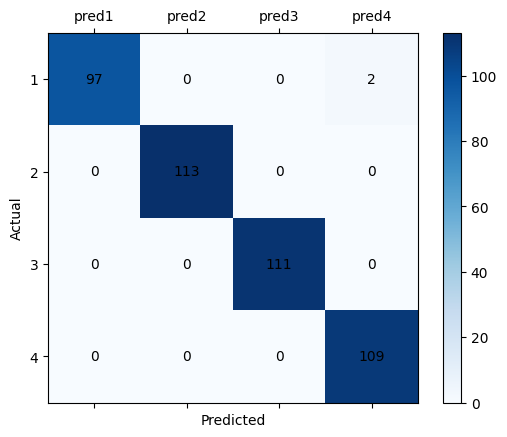

In [38]:
# Convert the list to a numpy array
# confusion_matrix = np.array(confusion_matrix)

# Plotting the confusion matrix
fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)

# Adding color bar
plt.colorbar(cax)

# Setting labels for axes
ax.set_xticklabels([''] + ['pred1', 'pred2', 'pred3', 'pred4'])
ax.set_yticklabels([''] + list(metrics.keys()))

# Adding text annotations
for i in range(len(confusion_matrix)):
    for j in range(len(confusion_matrix[i])):
        plt.text(j, i, str(confusion_matrix[i][j]), va='center', ha='center')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
plt.close()
image = Image.open(buf)
image = image.convert("RGB")
image = np.array(image)

image_tensor = torch.tensor(image).permute(2, 0, 1)  # Convert to CxHxW format

# Step 3: Log the image to TensorBoard
writer = SummaryWriter('runs/matplotlib_example')

# Add the image to TensorBoard
writer.add_image('Sine_Wave_Plot', image_tensor)

# Close the writer
writer.close()

In [ ]:
import io
from PIL import Image
import numpy as np

In [ ]:
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
image = Image.open(buf)
image = image.convert("RGB")
image = np.array(image)

<Figure size 640x480 with 0 Axes>

In [ ]:
image_tensor = torch.tensor(image).permute(2, 0, 1)  # Convert to CxHxW format

# Step 3: Log the image to TensorBoard
writer = SummaryWriter('runs/matplotlib_example')

# Add the image to TensorBoard
writer.add_image('Sine_Wave_Plot', image_tensor)

# Close the writer
writer.close()

AssertionError: size of input tensor and input format are different.         tensor shape: (480, 640), input_format: CHW

In [50]:
a = torch.tensor([1])
a

tensor([1])

In [51]:
a + 1

tensor([2])